Pruned model trained on SNLI tested on Semantic Phenomena and Function words (combined in one folder)

In [ ]:
!pip install transformers
!pip install datasets
import pandas as pd
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score
import os
from datasets import Dataset

os.environ["WANDB_DISABLED"] = "true"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/experiments_data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
adversarial_data.csv		  high_level_phenomena.csv	small_snli_dev_3k.csv
adversarial_data_final.csv	  logs				small_snli_test_1.5k.csv
adversarial_predictions.csv	  low_level_phenomena.csv	small_snli_test_3k.csv
adversarial_predictions_test.csv  model				small_snli_train_15k.csv
baseline_model_output		  model_output			small_snli_train_20k.csv
distilbert_baseline_snli_output   model_outputs			snli_1.0_dev.txt
distilbert_output		  multinli_1.0_dev_matched.csv	snli_1.0_test.txt
filtered_for_reasoning.csv	  multinli_1.0_train.csv	snli_dev.csv
final_adversarial_data.csv	  predictions_output.csv	snli_test.csv
final_baseline_model_output	  small_snli_dev_1.5k.csv	snli_train.csv


In [ ]:
!ls /content/drive/MyDrive/EXPERIMENTS_MODELS/pruned_baseline/ #pruned model

even_layer_pruning    single_layer_pruning_0  top_layer_pruning
middle_layer_pruning  single_layer_pruning_5


In [ ]:
def prepare_dataframe(file_path):
    """
    Reads the CSV file, processes it, and returns a DataFrame with 'input_text', 'label',
    and 'targeted_phenomenon' columns.
    """
    df = pd.read_csv(file_path)
    print(f"\nInitial DataFrame from {file_path}:\n")
    print(df.head())


    df['input_text'] = df['sentence1'] + " [SEP] " + df['sentence2']
    label_mapping = {'neutral': 0, 'contradiction': 1, 'entailment': 2}
    df['label'] = df['gold_label'].map(label_mapping)
    df = df[['input_text', 'label', 'targeted_phenomenon']].dropna()

    print("\nDataFrame after processing:\n")
    print(df.head())
    return df

# adversarial test dataset
adversarial_test_path = '/content/drive/MyDrive/experiments_data/final_adversarial_data.csv'
df_adversarial_test = prepare_dataframe(adversarial_test_path)

adversarial_test_dataset = Dataset.from_pandas(df_adversarial_test)

def tokenize_function(examples):
    return tokenizer(examples['input_text'], padding="max_length", truncation=True)

adversarial_test_dataset = adversarial_test_dataset.map(tokenize_function, batched=True)
adversarial_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])



Initial DataFrame from /content/drive/MyDrive/experiments_data/final_adversarial_data.csv:

  targeted_phenomenon     gold_label  id  \
0        comparatives  contradiction   1   
1        comparatives     entailment   2   
2        comparatives  contradiction   3   
3        comparatives     entailment   4   
4        comparatives     entailment   5   

                                           sentence1  \
0  The member countries have more people and expo...   
1  The member countries have more people and expo...   
2  An ACI system requires much less in terms of s...   
3  An ACI system requires much less in terms of s...   
4  We received and considered more than 200 comme...   

                                           sentence2  
0  The United States has not a larger gross domes...  
1  The United States has a larger gross domestic ...  
2  The ACI system is more resource-intensive than...  
3  The ACI system is not more resource-intensive ...  
4   There were not less than 1

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(predictions, label_ids, label_list):
    preds = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(label_ids, preds, average='weighted', zero_division=0)
    accuracy = accuracy_score(label_ids, preds)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

def evaluate_with_phenomena(trainer, dataset, label_list, output_csv_path=None, predictions_csv_path=None):
    predictions, labels, _ = trainer.predict(dataset)
    pred_labels = np.argmax(predictions, axis=1)

    print("\nOverall Classification Report:")
    print(classification_report(labels, pred_labels, target_names=label_list))

    cf_matrix = confusion_matrix(labels, pred_labels)
    print("\nOverall Confusion Matrix:")
    ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_list).plot()
    plt.show()

    dataset_df = pd.DataFrame({
        'input_text': dataset['input_text'],
        'label': labels,
        'pred_label': pred_labels,
        'targeted_phenomenon': dataset['targeted_phenomenon']
    })


    if predictions_csv_path:
        dataset_df.to_csv(predictions_csv_path, index=False)
        print(f"\nDetailed predictions saved to '{predictions_csv_path}'")

    summary_table = []

    # groups per funct words & sem phenomena
    phenomena_groups = dataset_df.groupby('targeted_phenomenon')

    for phenomenon, group in phenomena_groups:
        report = classification_report(
            group['label'],
            group['pred_label'],
            target_names=label_list,
            output_dict=True,
            zero_division=0
        )


        summary_table.append({
            'Phenomenon': phenomenon,
            'Precision (weighted avg)': report['weighted avg']['precision'],
            'Recall (weighted avg)': report['weighted avg']['recall'],
            'F1-score (weighted avg)': report['weighted avg']['f1-score']
        })

    summary_df = pd.DataFrame(summary_table)
    summary_df = summary_df.sort_values(by='F1-score (weighted avg)', ascending=False)

    print("\nSummary Table for All Targeted Phenomena:")
    print(summary_df)


    if output_csv_path:
        summary_df.to_csv(output_csv_path, index=False)
        print(f"\nSummary table saved to '{output_csv_path}'")

    return summary_df



Loading model from: /content/drive/MyDrive/EXPERIMENTS_MODELS/pruned_baseline/top_layer_pruning


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/EXPERIMENTS_MODELS/pruned_baseline/top_layer_pruning and are newly initialized: ['distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.0.output_layer_norm.bias', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'distilbert.transformer.layer.


Evaluating model: top_layer_pruning



Overall Classification Report:
               precision    recall  f1-score   support

      neutral       0.22      0.24      0.23       180
contradiction       0.38      0.46      0.42       280
   entailment       0.40      0.28      0.33       260

     accuracy                           0.34       720
    macro avg       0.33      0.33      0.32       720
 weighted avg       0.35      0.34      0.34       720


Overall Confusion Matrix:


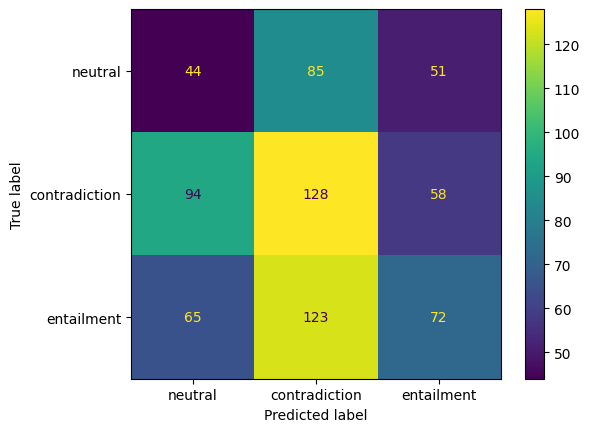


Detailed predictions saved to '/content/drive/MyDrive/EXPERIMENTS_PREDICTIONS/pruned_adversarial/top_layer_pruning_detailed_predictions.csv'

Summary Table for All Targeted Phenomena:
       Phenomenon  Precision (weighted avg)  Recall (weighted avg)  \
4    monotonicity                  0.442604                 0.4500   
3        counting                  0.416610                 0.4125   
2    conditionals                  0.343373                 0.4000   
7  quantification                  0.480968                 0.3000   
6    prepositions                  0.347127                 0.3375   
8    spatial data                  0.354545                 0.2875   
1    comparatives                  0.357308                 0.2625   
0         boolean                  0.289499                 0.3125   
5        negation                  0.222712                 0.2875   

   F1-score (weighted avg)  
4                 0.433210  
3                 0.402576  
2                 0.358748 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/EXPERIMENTS_MODELS/pruned_baseline/middle_layer_pruning and are newly initialized: ['distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.0.output_layer_norm.bias', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'distilbert.transformer.lay


Evaluating model: middle_layer_pruning



Overall Classification Report:
               precision    recall  f1-score   support

      neutral       0.24      0.28      0.26       180
contradiction       0.38      0.44      0.41       280
   entailment       0.38      0.28      0.32       260

     accuracy                           0.34       720
    macro avg       0.33      0.33      0.33       720
 weighted avg       0.35      0.34      0.34       720


Overall Confusion Matrix:


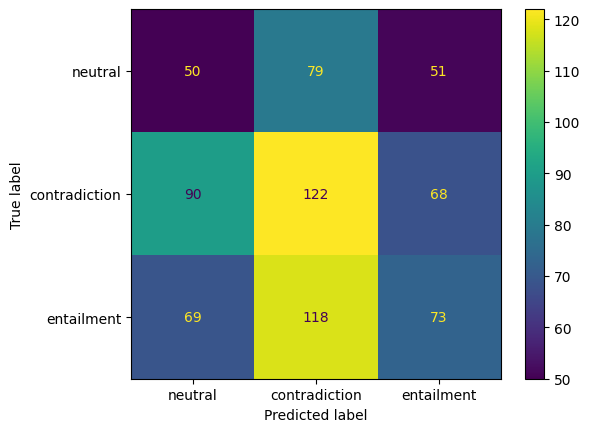


Detailed predictions saved to '/content/drive/MyDrive/EXPERIMENTS_PREDICTIONS/pruned_adversarial/middle_layer_pruning_detailed_predictions.csv'

Summary Table for All Targeted Phenomena:
       Phenomenon  Precision (weighted avg)  Recall (weighted avg)  \
3        counting                  0.440762                 0.4125   
4    monotonicity                  0.407789                 0.4125   
6    prepositions                  0.375072                 0.3750   
2    conditionals                  0.339572                 0.4000   
7  quantification                  0.406845                 0.2625   
0         boolean                  0.314757                 0.3375   
8    spatial data                  0.345443                 0.2750   
1    comparatives                  0.355357                 0.2625   
5        negation                  0.272768                 0.3250   

   F1-score (weighted avg)  
3                 0.413286  
4                 0.403332  
6                 0.3662

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/EXPERIMENTS_MODELS/pruned_baseline/even_layer_pruning and are newly initialized: ['distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.0.output_layer_norm.bias', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'distilbert.transformer.layer


Evaluating model: even_layer_pruning



Overall Classification Report:
               precision    recall  f1-score   support

      neutral       0.26      0.31      0.28       180
contradiction       0.40      0.39      0.39       280
   entailment       0.40      0.35      0.37       260

     accuracy                           0.36       720
    macro avg       0.35      0.35      0.35       720
 weighted avg       0.36      0.36      0.36       720


Overall Confusion Matrix:


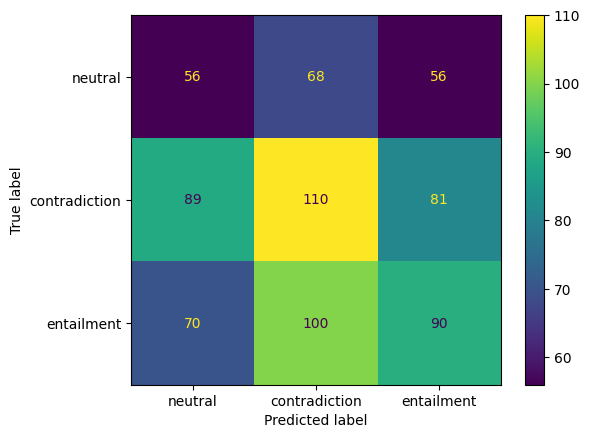


Detailed predictions saved to '/content/drive/MyDrive/EXPERIMENTS_PREDICTIONS/pruned_adversarial/even_layer_pruning_detailed_predictions.csv'

Summary Table for All Targeted Phenomena:
       Phenomenon  Precision (weighted avg)  Recall (weighted avg)  \
3        counting                  0.466890                 0.4250   
4    monotonicity                  0.424881                 0.4250   
2    conditionals                  0.405049                 0.4375   
0         boolean                  0.362689                 0.3750   
8    spatial data                  0.387486                 0.3250   
6    prepositions                  0.342145                 0.3500   
5        negation                  0.374271                 0.3500   
1    comparatives                  0.346667                 0.2750   
7  quantification                  0.365510                 0.2375   

   F1-score (weighted avg)  
3                 0.431736  
4                 0.416161  
2                 0.411568

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/EXPERIMENTS_MODELS/pruned_baseline/single_layer_pruning_0 and are newly initialized: ['distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.0.output_layer_norm.bias', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'distilbert.transformer.l


Evaluating model: single_layer_pruning_0



Overall Classification Report:
               precision    recall  f1-score   support

      neutral       0.27      0.33      0.30       180
contradiction       0.40      0.39      0.39       280
   entailment       0.40      0.35      0.37       260

     accuracy                           0.36       720
    macro avg       0.36      0.36      0.35       720
 weighted avg       0.37      0.36      0.36       720


Overall Confusion Matrix:


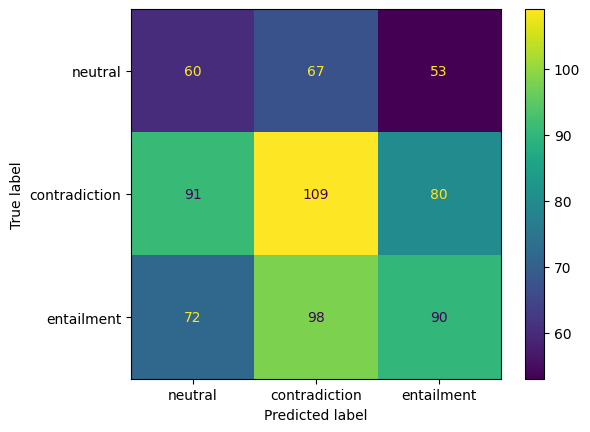


Detailed predictions saved to '/content/drive/MyDrive/EXPERIMENTS_PREDICTIONS/pruned_adversarial/single_layer_pruning_0_detailed_predictions.csv'

Summary Table for All Targeted Phenomena:
       Phenomenon  Precision (weighted avg)  Recall (weighted avg)  \
3        counting                  0.475093                 0.4500   
4    monotonicity                  0.418861                 0.4250   
2    conditionals                  0.390625                 0.4000   
0         boolean                  0.385671                 0.3875   
8    spatial data                  0.399098                 0.3375   
6    prepositions                  0.338183                 0.3500   
7  quantification                  0.408861                 0.2750   
1    comparatives                  0.372560                 0.2875   
5        negation                  0.327894                 0.3250   

   F1-score (weighted avg)  
3                 0.453929  
4                 0.417066  
2                 0.39

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/EXPERIMENTS_MODELS/pruned_baseline/single_layer_pruning_5 and are newly initialized: ['distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.0.output_layer_norm.bias', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'distilbert.transformer.l


Evaluating model: single_layer_pruning_5



Overall Classification Report:
               precision    recall  f1-score   support

      neutral       0.25      0.33      0.29       180
contradiction       0.40      0.40      0.40       280
   entailment       0.40      0.32      0.36       260

     accuracy                           0.35       720
    macro avg       0.35      0.35      0.35       720
 weighted avg       0.37      0.35      0.36       720


Overall Confusion Matrix:


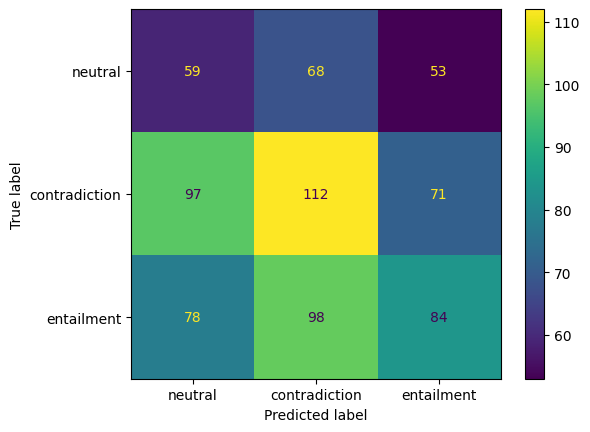


Detailed predictions saved to '/content/drive/MyDrive/EXPERIMENTS_PREDICTIONS/pruned_adversarial/single_layer_pruning_5_detailed_predictions.csv'

Summary Table for All Targeted Phenomena:
       Phenomenon  Precision (weighted avg)  Recall (weighted avg)  \
3        counting                  0.486998                 0.4750   
4    monotonicity                  0.417264                 0.4250   
2    conditionals                  0.392708                 0.4125   
6    prepositions                  0.366071                 0.3625   
8    spatial data                  0.382157                 0.3125   
5        negation                  0.366667                 0.3750   
0         boolean                  0.300033                 0.3375   
1    comparatives                  0.347455                 0.2625   
7  quantification                  0.366458                 0.2250   

   F1-score (weighted avg)  
3                 0.475367  
4                 0.419217  
2                 0.39

In [ ]:
def evaluate_all_pruned_models(base_model_path, dataset, label_list, output_base_path):
    #subdirectories (each representing a pruned model)
    model_dirs = [d for d in os.listdir(base_model_path) if os.path.isdir(os.path.join(base_model_path, d))]

    for model_name in model_dirs:
        #full path for each pruned model
        model_path = os.path.join(base_model_path, model_name)

        #tokenizer and model for each pruned configuration
        print(f"\nLoading model from: {model_path}")
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSequenceClassification.from_pretrained(model_path)

        trainer = Trainer(model=model, tokenizer=tokenizer)

        #paths for saving preds
        output_csv_path = os.path.join(output_base_path, f"{model_name}_summary_results.csv")
        predictions_csv_path = os.path.join(output_base_path, f"{model_name}_detailed_predictions.csv")

        #evaluation
        print(f"\nEvaluating model: {model_name}")
        evaluate_with_phenomena(trainer, dataset, label_list, output_csv_path, predictions_csv_path)

base_model_path = "/content/drive/MyDrive/EXPERIMENTS_MODELS/pruned_baseline"
output_base_path = "/content/drive/MyDrive/EXPERIMENTS_PREDICTIONS/pruned_adversarial"
label_list = ["neutral", "contradiction", "entailment"]

evaluate_all_pruned_models(base_model_path, adversarial_test_dataset, label_list, output_base_path)
